In [ ]:
from PIL import Image
from tqdm import tqdm
from glob import glob

import numpy as np
import json
import os

import matplotlib.pyplot as plt

In [ ]:
# Google Drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/Training'):
    os.mkdir('data/Training')

In [ ]:
# Dataset unzip
!unzip -q /content/drive/MyDrive/AI_Factory/data/[원천]돼지_bbox.zip -d /content/data/Training/pig_image
!unzip -q /content/drive/MyDrive/AI_Factory/data/[원천]소_bbox.zip -d /content/data/Training/cow_image

!unzip -q /content/drive/MyDrive/AI_Factory/data/[라벨]돼지_bbox.zip -d /content/data/Training/pig_label
!unzip -q /content/drive/MyDrive/AI_Factory/data/[라벨]소_bbox.zip -d /content/data/Training/cow_label

In [ ]:
# Data 불러오기
train_pig_image = glob('/content/data/Training/pig_image/*.jpg')
train_cow_image = glob('/content/data/Training/cow_image/*.jpg')
train_pig_label = glob('/content/data/Training/pig_label/*.json')
train_cow_label = glob('/content/data/Training/cow_label/*.json')

### Cow vs Pig

In [ ]:
train_pig = len(train_pig_image)
train_cow = len(train_cow_image)
print('Train - Pig:', train_pig, '& Cow:', train_cow)
print()
print(f'Pig : Cow = {train_pig/(train_pig+train_cow):.2f} : {train_cow/(train_pig+train_cow):.2f}')

Train - Pig: 4303 & Cow: 12152

Pig : Cow = 0.26 : 0.74


### Image Size 분포

In [ ]:
# Train Dataset에서의 Pig의 Image Size
train_pig_size_dict = {}
for pig in tqdm(train_pig_image):
    image_size = Image.open(pig).size
    if image_size in train_pig_size_dict.keys():
        train_pig_size_dict[image_size] += 1
    else:
        train_pig_size_dict[image_size] = 1

100%|██████████| 4303/4303 [00:06<00:00, 635.64it/s]


In [ ]:
# Train Dataset에서의 Cow의 Image Size
train_cow_size_dict = {}
for cow in tqdm(train_cow_image):
    image_size = Image.open(cow).size
    if image_size in train_cow_size_dict.keys():
        train_cow_size_dict[image_size] += 1
    else:
        train_cow_size_dict[image_size] = 1

100%|██████████| 12152/12152 [00:16<00:00, 734.90it/s]


In [ ]:
print('Train에서 Pig의 Image Size:', train_pig_size_dict)
print('Train에서 Cow의 Image Size:', train_cow_size_dict)

Train에서 Pig의 Image Size: {(1920, 1080): 3131, (1280, 960): 1172}
Train에서 Cow의 Image Size: {(1920, 1080): 12152}


### Box 개수 시각화

In [ ]:
def ratio_check(w, h):
    """
    object bounding box의 비율을 확인하는 함수
    Args:
        w: object bounding box의 width
        h: object bounding box의 height
    Return:
        w:h=1.5:1 보다 크게 w가 더 길 경우 => 'horizontally'
        w:h=1:1.5 보다 크게 h가 더 길 경우 => 'vertically'
        그 외 => 'square'
    """
    if w / (w+h) >= 0.6: # 1.5 : 1 보다 더 큰 ratio일 경우
        return 'horizontally'
    elif h / (w+h) >= 0.6:
        return 'vertically'
    else:
        return 'square'

def area_check(w, h):
    """
    object bounding box의 크기를 확인하는 함수
    Args:
        w: object bounding box의 width
        h: object boudning box의 height
    Return
        bounding box의 넓이가 10만 이상일 경우: 'very_large'
        bounding box의 넓이가 5만 이상일 경우: 'large'
        bounding box의 넓이가 1만 이상일 경우: 'medium'
        bounding box의 넓이가 1천 이상일 경우: 'small'
        bounding box의 넓이가 1백 이상일 경우: 'very_small'
        그 외: 'out'
    """
    if w * h >= 100000:
        return 'very_large'
    elif w*h >= 50000:
        return 'large'
    elif w*h >= 10000:
        return 'medium'
    elif w*h >= 1000:
        return 'small'
    elif w*h >= 100:
        return 'very_small'
    elif w * h < 100:
        return 'out'

In [ ]:
# Train Pig data에 대한 box의 개수 및 size
train_pig_box_count = []
train_pig_box_size = {'horizontally':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      },
                      'vertically':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0      
                      },
                      'square':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      }}

for label in tqdm(train_pig_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    train_pig_box_count.append(box_count)

    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1

        ratio = ratio_check(w,h)
        area = area_check(w, h)

        train_pig_box_size[ratio][area] += 1

100%|██████████| 4303/4303 [00:00<00:00, 11269.70it/s]


In [ ]:
# Train Cow data에 대한 box의 개수 및 size

train_cow_box_count = []
train_cow_box_size = {'horizontally':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      },
                      'vertically':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0      
                      },
                      'square':{
                          'very_large': 0,
                          'large': 0,
                          'medium': 0,
                          'small': 0,
                          'very_small': 0,
                          'out': 0
                      }}

for label in tqdm(train_cow_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    train_cow_box_count.append(box_count)

    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1

        ratio = ratio_check(w,h)
        area = area_check(w, h)

        train_cow_box_size[ratio][area] += 1

100%|██████████| 12152/12152 [00:00<00:00, 14798.01it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


(array([1990., 2408., 2985., 2099., 1314.,  661.,  400.,  222.,   56.,
          17.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

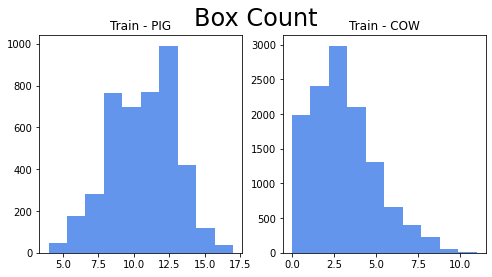

In [ ]:
# Box의 개수 시각화
plt.figure(figsize = (8, 4))
plt.suptitle('Box Count', fontsize=24)

plt.subplot(121)
plt.subplot(121).set_title('Train - PIG')
plt.hist(train_pig_box_count, color='cornflowerblue')

plt.subplot(122)
plt.subplot(122).set_title('Train - COW')
plt.hist(train_cow_box_count, color='cornflowerblue')

### Box 비율 시각화

In [ ]:
# Train Pig
train_pig_box_size_horizontal = 0
train_pig_box_size_vertical = 0
train_pig_box_size_square = 0

for v in train_pig_box_size['horizontally'].values():
    train_pig_box_size_horizontal += v
for v in train_pig_box_size['vertically'].values():
    train_pig_box_size_vertical += v
for v in train_pig_box_size['square'].values():
    train_pig_box_size_square += v

# Train Cow
train_cow_box_size_horizontal = 0
train_cow_box_size_vertical = 0
train_cow_box_size_square = 0

for v in train_cow_box_size['horizontally'].values():
    train_cow_box_size_horizontal += v
for v in train_cow_box_size['vertically'].values():
    train_cow_box_size_vertical += v
for v in train_cow_box_size['square'].values():
    train_cow_box_size_square += v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


([<matplotlib.axis.XTick at 0x7f84ad928390>,
 [Text(0, 0, 'Horizontal'), Text(0, 0, 'Vertical'), Text(0, 0, 'Square')])

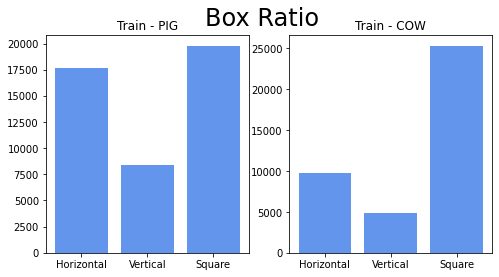

In [ ]:
# Box의 ratio 시각화
title_font = {
    'fontsize': 40,
    'fontweight': 'bold'
}

plt.figure(figsize = (8, 4))
plt.suptitle('Box Ratio', fontsize=24)

plt.subplot(121)
plt.subplot(121).set_title('Train - PIG')
x = np.arange(3)
count = [train_pig_box_size_horizontal, train_pig_box_size_vertical, train_pig_box_size_square]
names = ['Horizontal', 'Vertical', 'Square']
plt.bar(x, count, color='cornflowerblue')
plt.xticks(x, names)

plt.subplot(122)
plt.subplot(122).set_title('Train - COW')
x = np.arange(3)
count = [train_cow_box_size_horizontal, train_cow_box_size_vertical, train_cow_box_size_square]
names = ['Horizontal', 'Vertical', 'Square']
plt.bar(x, count, color='cornflowerblue')
plt.xticks(x, names)

### Box 크기 시각화

In [ ]:
# Train Pig
train_pig_very_large = 0
train_pig_large = 0
train_pig_medium = 0
train_pig_small = 0
train_pig_very_small = 0
train_pig_out = 0

for k in train_pig_box_size.keys():
    tmp_dict = train_pig_box_size[k]
    for k, v in tmp_dict.items():
        if k == 'very_large':
            train_pig_very_large += v
        elif k == 'large':
            train_pig_large += v
        elif k == 'very_small':
            train_pig_very_small += v
        elif k == 'small':
            train_pig_small += v
        elif k == 'medium':
            train_pig_medium += v
        else:
            train_pig_out += v

# Train Cow
train_cow_very_large = 0
train_cow_large = 0
train_cow_medium = 0
train_cow_small = 0
train_cow_very_small = 0
train_cow_out = 0

for k in train_cow_box_size.keys():
    tmp_dict = train_cow_box_size[k]
    for k, v in tmp_dict.items():
        if k == 'very_large':
            train_cow_very_large += v
        elif k == 'large':
            train_cow_large += v
        elif k == 'very_small':
            train_cow_very_small += v
        elif k == 'small':
            train_cow_small += v
        elif k == 'medium':
            train_cow_medium += v
        else:
            train_cow_out += v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


([<matplotlib.axis.XTick at 0x7f84ad554450>,
 [Text(0, 0, 'Very_Large'),
  Text(0, 0, 'Large'),
  Text(0, 0, 'Medium'),
  Text(0, 0, 'Small'),
  Text(0, 0, 'Very_Small'),
  Text(0, 0, 'Out')])

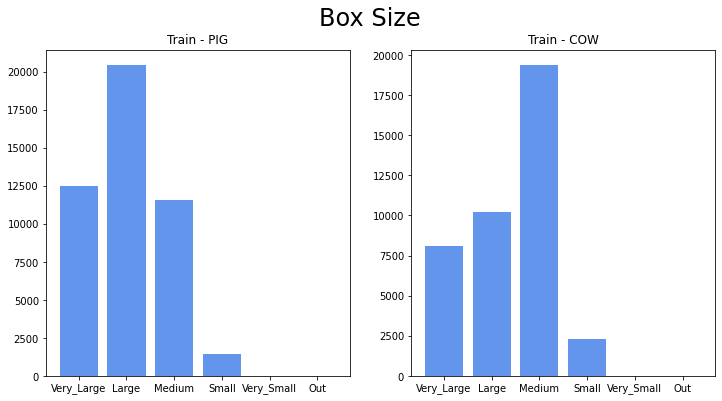

In [ ]:
# Box의 크기 시각화
plt.figure(figsize = (12, 6))
plt.suptitle('Box Size', fontsize=24)

plt.subplot(121)
plt.subplot(121).set_title('Train - PIG')
x = np.arange(6)
count = [train_pig_very_large, train_pig_large, train_pig_medium, train_pig_small, train_pig_very_small, train_pig_out]
names = ['Very_Large', 'Large', 'Medium', 'Small', 'Very_Small', 'Out']
plt.bar(x, count, color='cornflowerblue')
plt.xticks(x, names)

plt.subplot(122)
plt.subplot(122).set_title('Train - COW')
x = np.arange(6)
count = [train_cow_very_large, train_cow_large, train_cow_medium, train_cow_small, train_cow_very_small, train_cow_out]
names = ['Very_Large', 'Large', 'Medium', 'Small', 'Very_Small', 'Out']
plt.bar(x, count, color='cornflowerblue')
plt.xticks(x, names)

### Box의 크기가 Small인 Bounding Box의 크기 세분화하여 시각화

In [ ]:
def small_area_check(w, h):
    """넓이가 1만 이하인 Bounding box를 세분화하는 함수"""
    if 1000 <= w * h < 2000:
        return 1
    elif 2000 <= w * h < 4000:
        return 2
    elif 4000 <= w * h < 6000:
        return 3
    elif 6000 <= w * h < 8000:
        return 4
    elif 8000 <= w * h < 10000:
        return 5

In [ ]:
# Train Pig data에 대한 box의 개수 및 size
train_pig_box_small_check = {1:0,
                             2:0,
                             3:0,
                             4:0,
                             5:0}

for label in tqdm(train_pig_label):
    with open(label, "r") as data:
        label_data = json.load(data)
    box_info = label_data['label_info']['annotations']
    
    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        area = small_area_check(w, h)

        if area:
            train_pig_box_small_check[area] += 1

# Train Cow data에 대한 box의 개수 및 size
train_cow_box_small_check = {1:0,
                             2:0,
                             3:0,
                             4:0,
                             5:0}

for label in tqdm(train_cow_label):
    with open(label, "r") as data:
        label_data = json.load(data)
    box_info = label_data['label_info']['annotations']
    
    for box in box_info:
        bbox = box['bbox']
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        area = small_area_check(w, h)

        if area:
            train_cow_box_small_check[area] += 1

100%|██████████| 12152/12152 [00:00<00:00, 15714.56it/s]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


([<matplotlib.axis.XTick at 0x7f84ad281c10>,
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5')])

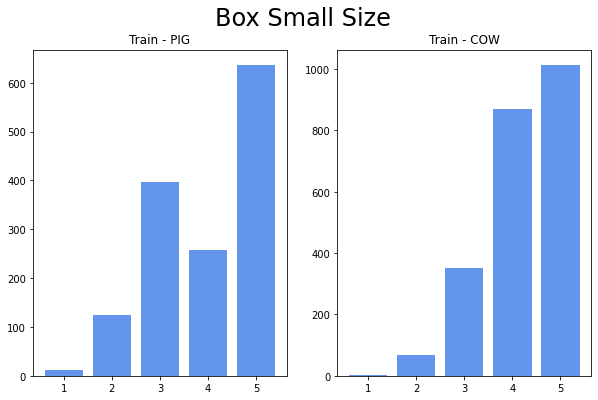

In [ ]:
# Box의 크기 시각화

plt.figure(figsize = (10, 6))
plt.suptitle('Box Small Size', fontsize=24)

plt.subplot(121)
plt.subplot(121).set_title('Train - PIG')
x = np.arange(5)
count = [train_pig_box_small_check[1], train_pig_box_small_check[2], train_pig_box_small_check[3], train_pig_box_small_check[4], train_pig_box_small_check[5]]
names = ['1', '2', '3', '4', '5']
plt.bar(x, count, color='cornflowerblue')
plt.xticks(x, names)

plt.subplot(122)
plt.subplot(122).set_title('Train - COW')
x = np.arange(5)
count = [train_cow_box_small_check[1], train_cow_box_small_check[2], train_cow_box_small_check[3], train_cow_box_small_check[4], train_cow_box_small_check[5]]
names = ['1', '2', '3', '4', '5']
plt.bar(x, count, color='cornflowerblue')
plt.xticks(x, names)

In [ ]:
print('넓이가 4000이하인 Data의 개수')
print(f'Train - PIG: {train_pig_box_small_check[1] + train_pig_box_small_check[2]} / 전체 Box 개수에 대한 비율: {(train_pig_box_small_check[1] + train_pig_box_small_check[2])/sum(train_pig_box_count):.4f}')
print(f'Train - COW: {train_cow_box_small_check[1] + train_cow_box_small_check[2]} / 전체 Box 개수에 대한 비율: {(train_cow_box_small_check[1] + train_cow_box_small_check[2])/sum(train_cow_box_count):.4f}')

넓이가 4000이하인 Data의 개수
Train - PIG: 137 / 전체 Box 개수에 대한 비율: 0.0030
Train - COW: 71 / 전체 Box 개수에 대한 비율: 0.0018


### Box가 없는 이미지

In [ ]:
# Train Pig data에 대한 box가 없는 이미지의 개수
train_pig_no_box = 0

for label in tqdm(train_pig_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    if box_count == 0:
        train_pig_no_box += 1

# Train Cow data에 대한 box가 없는 이미지의 개수
train_cow_no_box = 0

for label in tqdm(train_cow_label):
    with open(label, "r") as data:
        label_data = json.load(data)

    box_info = label_data['label_info']['annotations']
    
    box_count = len(box_info)
    if box_count == 0:
        train_cow_no_box += 1

100%|██████████| 12152/12152 [00:00<00:00, 18241.41it/s]


In [ ]:
print('Train - No Box Pig Image:', train_pig_no_box)
print('Train - No Box Cow Image:', train_cow_no_box)

Train - No Box Pig Image: 0
Train - No Box Cow Image: 3


### Conclusion

- Cow Dataset vs Pig dataset
    - Data의 분포가 "Cow : Pig = 3 : 1"
    - Train / Valid split할 경우, 골고루 분포하도록 진행
- Image size 분포
    - 대부분의 Image의 크기는 1920x1080
    - Pig Data에서 일부 image의 크기가 1280x960
    - 좌표변환 적용시, Image size를 고려하여 변환
- Box의 개수에 따른 분포
    - pig data와 cow data에서 Box의 개수가 서로 상이하게 분포
    - Train / Valid split할 경우, 각 image별로 가지는 Box의 개수에 따라서 골고루 분포할 수 있도록 진행.
- Box의 비율에 따른 분포
    - pig data와 cow data에서 Box의 비율은 유사
    - Train / Valid split할 경우, Random split 진행
- Box의 크기에 따른 분포
    - pig data, cow data 모두 small size bounding box (넓이: 1000~10000)의 개수가 상대적으로 적음.
    - small size bounding box를 지울 것인가? => 선택의 문제 (본 과정에서는 지우지 않음)
- Small size bounding box에 대한 세밀한 분포 조사
    - 넓이가 4000이하인 Data의 개수가 pig data 137개, cow data 71개
    - 전체 Data에 대한 비율 (137 -> 0.003, 71 -> 0.0018). 즉, 0.3%, 0.18%
    - 넓이가 4000이하인 Bounding Box를 지울 것인가? => 선택의 문제 (본 과정에서는 지우지 않음)
- Box가 없는 이미지 분포
    - Cow Image에서 3개 존재
    - White Noise로 판단하여 삭제하지 않음.